In [185]:
# Denna modul är för att testa olika modeller och parametrar 
# för att hitta den bästa modellen för att förutsäga kryptovalutor
# Dessutom testar jag att ta med inflation och guldpriser som features
# Nu används yfinance för att hämta data från Yahoo Finance
# Testa också att hämta data från Binance

# 
# TODO: Gör viss preprocessing per kryptovaluta till separate df
# TODO: Gör en merge av utvalda kryptovalutors df
# TODO: Sätt tomorrows up/down (1/0) till en kolumn i df som target
# TODO: Lägg till guldpriser som feature
# HACK: Vi har nu 6 olika Ratio och Trend per TIcker och Datum - FIXA!!
# HACK: Trend måste få en annan definition typ Ratio

# TODO: Gör en split av df till train och test
# TODO: Gör en GridSearchCV för en pipeline som innehåller en StandardScaler för olika modeller
# TODO: Skall vi gå vidare med övermorgon också?

# TODO: Gå vidare med logiken i my_crypto.py

In [186]:
import sklearn
import xgboost as xgb
import catboost
from catboost import CatBoostClassifier

# from pytrends.request import TrendReq
# import pytrends
import sys
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# plt.style.use('fivethirtyeight')
import plotly.express as px
import streamlit as st
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

#Import other useful libraries
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from IPython.display import display
# set display witdh to 200
pd.set_option('display.width', 200)
# set display height to 500
pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
# pd.options.display.precision = 4      # default 6
import logging

# Starta upp logging och inkluder rad nummer
logging.basicConfig(level=logging.INFO, filemode='w', filename='krypto.log', force=True,
                    encoding='utf-8', format= '%(asctime)s - %(levelname)s - %(lineno)d - %(message)s')
logging.info('Startar')


In [187]:
print('Versioner av softvara som används i denna notebook:')
# print numpy version
print('numpy=={}'.format(np.__version__))
# print pandas version
print('pandas=={}'.format(pd.__version__))
# print matplotlib version
print('matplotlib=={}'.format(plt.matplotlib.__version__)) # type: ignore
# print yfinance version
print('yfinance=={}'.format(yf.__version__))
# print pytreands version
print('pytrends==4.8.0') 
# print python-dateutil version
print('python-dateutil==2.8.2')
# print ta version
print('ta==0.10.2')
# print streamlit version
print('streamlit=={}'.format(st.__version__))
print('xgboost=={}'.format(xgb.__version__))
print('catboost=={}'.format(catboost.__version__))

print('sklearn=={}'.format(sklearn.__version__))
#print google version
print('google-crc32==1.1.2')
# print pandas-ta version
print('pandas-ta==0.3.14b0')
# print plotly version
print('plotly==5.3.1')



Versioner av softvara som används i denna notebook:
numpy==1.23.5
pandas==1.4.4
matplotlib==3.7.0
yfinance==0.2.12
pytrends==4.8.0
python-dateutil==2.8.2
ta==0.10.2
streamlit==1.14.0
xgboost==1.7.1
catboost==1.1.1
sklearn==1.0.2
google-crc32==1.1.2
pandas-ta==0.3.14b0
plotly==5.3.1


In [188]:
# TODO Vilka kryptovalutor ska vi använda?
tickers = ['BTC-USD','ETH-USD','BCH-USD','XRP-USD','ZRX-USD','GLD']
horizons=[2,5,15,30,60,90,250]

In [189]:
def beräkna_rolling_mean(df, ticker_names, window=20):
    # Funktionen används inte just nu
    rolling_mean=pd.DataFrame()
    for ticker_name in ticker_names:
        df[ticker_name+'-rolling']= df[ticker_name].rolling(window=window).mean()
        
    df.dropna(inplace=True)   
    return df   

def beräkna_cumulative_return(df, ticker_names):
    # Funktionen används inte just nu
    cumulative_return={}
    for ticker_name in ticker_names:
        cumulative_return[ticker_name] = (df[ticker_name].iloc[-1]/df[ticker_name].iloc[0]-1)
    return cumulative_return

## Get inflation data US and SE

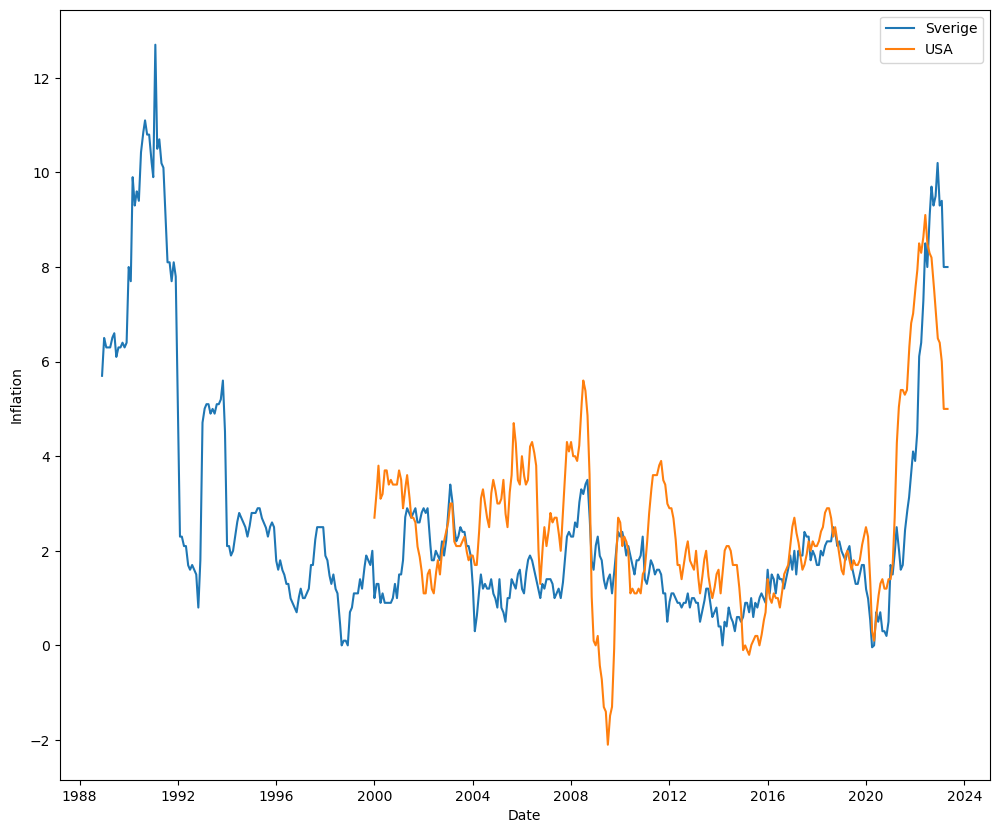

In [190]:
def add_horizon_columns(inflation, horizons):
    # print(horizons)
    for horizon in  horizons:
        # print(horizon)
        inflation['US_inflation_'+str(horizon)] = inflation['US_inflation'].rolling(horizon, 1).mean()
        inflation['SE_inflation_'+str(horizon)] = inflation['SE_inflation'].rolling(horizon, 1).mean()
                
        # print(inflation.columns)        
    return inflation


def initiate_data(inflation, df_dates, lang_dict, value_name):
    # display(inflation)
    inflation = inflation.melt(id_vars=['Year'], var_name='month', value_name=value_name)

    # use lang_dict to translate month names to numbers
    inflation['month'] = inflation['month'].map(lang_dict)

    inflation['Date'] = pd.to_datetime(inflation['Year'].astype(str) + '-' + inflation['month'].astype(str))
    inflation.set_index('Date', inplace=True)
    inflation.drop(['Year', 'month'], axis=1, inplace=True)
    inflation = df_dates.merge(inflation, how='left', left_on='Date', right_index=True)
    inflation.set_index('Date', inplace=True)
    inflation[value_name] = inflation[value_name].astype(str)
    inflation[value_name] = inflation[value_name].str.replace(',', '.')
    inflation[value_name] = inflation[value_name].str.replace(chr(8209), chr(45))
    inflation[value_name] = inflation[value_name].astype(float)
    inflation[value_name].interpolate(method='linear', inplace=True)
    return inflation


@st.cache_data
def get_inflation_data(graph=False):
    # Explain this function here        
    # Create a dataframe with dates from 1988-12-01 to today
    df_dates = pd.DataFrame(pd.date_range('1988-12-01', pd.to_datetime('today').date()), columns=['Date'])
    
    US_inflation = pd.read_html('https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
    US_inflation = US_inflation[0]
    # replace the cell including string starting with "Avail" with the NaN
    US_inflation.replace(to_replace=r'^Avail.*$', value=np.nan, regex=True, inplace=True)
    # set the first row as the header and drop the first row
    US_inflation.columns = US_inflation.iloc[0]
    US_inflation.drop(US_inflation.index[0], inplace=True)
    US_inflation.drop('Ave', axis=1, inplace=True)

    SE_inflation = pd.read_html('https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
    SE_inflation = SE_inflation[0]
    SE_inflation.rename(columns={'År': 'Year'}, inplace=True)

    se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6', Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
    us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6', Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')
    #
    SE_inflation = initiate_data(SE_inflation, df_dates, se_dict, value_name='SE_inflation')
    SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10  # SE_inflation is in percent, divide by 10 to get decimal
    US_inflation = initiate_data(US_inflation, df_dates, us_dict,  value_name='US_inflation')

    if graph:
        # Do a simple plot
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.plot(SE_inflation.index, SE_inflation['SE_inflation'], label='Sverige')
        ax.plot(US_inflation.index, US_inflation['US_inflation'], label='USA')
        ax.set_xlabel('Date')
        ax.set_ylabel('Inflation')
        ax.legend()
        plt.show()

    # concat and set one column to US_index and the other to SE_index
    inflations = pd.concat([US_inflation, SE_inflation], axis=1)
    inflations = inflations.dropna()
    inflations = add_horizon_columns(inflations, [75,90,250])
    return inflations

inflations = get_inflation_data(graph=True)

In [191]:
display(list(inflations.columns))

['US_inflation',
 'SE_inflation',
 'US_inflation_75',
 'SE_inflation_75',
 'US_inflation_90',
 'SE_inflation_90',
 'US_inflation_250',
 'SE_inflation_250']

In [192]:
# fill up a dataframe with all days from 2005 up to today and set it as index
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


## Get Gold data from yfinance

<Axes: title={'center': 'Gold Price'}, xlabel='Date'>

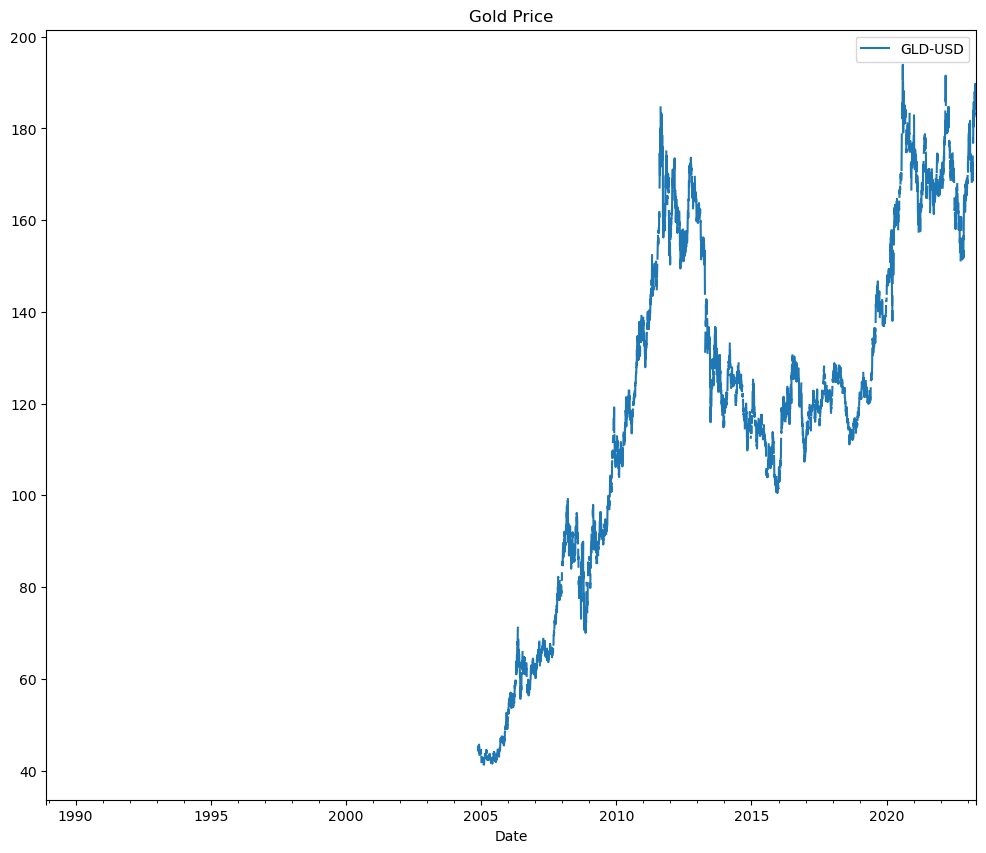

In [193]:
def get_gold_data():
    df_dates = pd.DataFrame(pd.date_range(
        '1988-12-01', pd.to_datetime('today').date()), columns=['Date'])
    df_dates.set_index('Date', inplace=True)
    # Hämta historiska guldprisdata (GLD är ticker-symbolen för SPDR Gold Shares ETF)
    gld_data = yf.download('GLD', end=dt.today().date(), progress=False)
    # gld_data.set_index('Date', inplace=True)
    # Behåll endast 'Close' priser och döp om kolumnen till 'GLD-USD'
    gld_data = gld_data[['Close']].rename(columns={'Close': 'GLD-USD'})
    gld_data = df_dates.merge(gld_data, how='left', left_on='Date', right_index=True)
    
    return gld_data
df_gold=get_gold_data()

df_gold.plot(figsize=(12, 10), title='Gold Price')


## Ladda ner all data

In [194]:
def get_all(tickers):
    # Funktionen används inte just nu    
    df = pd.DataFrame()
    for ticker in tickers:
        # all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

df_org = get_all(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [195]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    
    if train[target].nunique() < 2:
        print('kolumner i train',train.columns)
        print('kolumner i test',test.columns)
        print('target',target)
        print('predictors',predictors)
        print('train\n',train[target].value_counts())
        print('test\n',test[target].value_counts())
        print(
            f"Skipping training for target {target} as it has only one unique value in the training data.")
        # stäng ner programmet
        sys.exit()
        
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined


### Beräkna nya kolumner (predictors)

In [231]:
def create_predictors(df_, ticker, target, horizons=[2,5,60,250], ETH_BTC=False):
    df = df_.copy()
    ticker_name = ticker[:3]
    # print(ticker_name)
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    predictors=[]
     
    if ETH_BTC: 
        df['ETH_BTC_ratio'] = df['ETH-USD']/df['BTC-USD']
        predictors += ['ETH_BTC_ratio']
        
        df['ETH_BTC_lag1'] = df['ETH_BTC_ratio'].shift(1)
        predictors += ['ETH_BTC_lag1']
        
        df['ETH_BTC_lag2'] = df['ETH_BTC_ratio'].shift(2)
        predictors += ['ETH_BTC_lag2']
        
        if ticker not in ['BTC-USD', 'ETH-USD']:
            df[ticker_name+'_BTC_ratio'] = df[ticker]/df['BTC-USD']
            predictors += [ticker_name+'_BTC_ratio']
        
            df[ticker_name+'_BTC_lag1'] = df[ticker_name+'_BTC_ratio'].shift(1)
            predictors += [ticker_name+'_BTC_lag1']
            
            df[ticker_name+'_BTC_lag2'] = df[ticker_name+'_BTC_ratio'].shift(2)
            predictors += [ticker_name+'_BTC_lag2']
            
            df[ticker_name+'_ETH_ratio'] = df[ticker]/df['ETH-USD']
            predictors += [ticker_name+'_ETH_ratio']
        
            df[ticker_name+'_ETH_lag1'] = df[ticker_name+'_ETH_ratio'].shift(1)
            predictors += [ticker_name+'_ETH_lag1']
            
            df[ticker_name+'_ETH_lag2'] = df[ticker_name+'_ETH_ratio'].shift(2)
            predictors += [ticker_name+'_ETH_lag2']
    
    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    # df.dropna(inplace=True)

    hpref = 'GLD_' if ticker == 'GLD' else ''
    for horizon in horizons:
        rolling_averages = df.rolling(horizon, min_periods=1).mean()

        ratio_column = f"{hpref}Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]
        
        rolling = df.rolling(horizon,closed='left', min_periods=1).mean()
        
        trend_column = f"{hpref}Trend_{horizon}"
        target_name = 'Tomorrow' if target=='y1' else 'After_tomorrow'
        df[trend_column] = rolling[target_name]  

        predictors += [ratio_column, trend_column]

    return df, predictors


# Skapa en GridSearchCV för olika modeller

In [197]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


In [198]:
### get the data ###
df_grid = get_all(tickers)
df_inflations = get_inflation_data(graph=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Vi gör viss preprocessing för en valuta i taget - nya kolumner

In [199]:
display(tickers)
df_grid.shape


['BTC-USD', 'ETH-USD', 'BCH-USD', 'XRP-USD', 'ZRX-USD', 'GLD']

(3145, 6)

In [232]:
### preprocessing ###
df = pd.DataFrame()
target = 'y1'  # tomorrow
for ticker in tickers:

    # print(ticker)
    df_temp, pred = create_predictors(
        df_grid[[ticker]], ticker, target, horizons=horizons)
    df_temp = df_temp.reset_index()
    df_temp['Ticker'] = ticker
    df = pd.concat([df, df_temp], axis=0)

print('Dessa skall vara lika',sum(df.Date.value_counts()==6)*6,'=',len(df) )
df.Date.value_counts()

Dessa skall vara lika 18870 = 18870


2014-09-17    6
2020-06-06    6
2020-06-08    6
2020-06-09    6
2020-06-10    6
             ..
2017-08-03    6
2017-08-04    6
2017-08-05    6
2017-08-06    6
2023-04-27    6
Name: Date, Length: 3145, dtype: int64

In [233]:
print('df innan merge')
df=df.set_index('Date')
print(df.shape)
df=df.merge(df_inflations, left_index=True,
          right_index=True, how='left')

# df = df.merge(df_gold, left_index=True,  # Behövs inte - redan med i tickers
#           right_index=True, how='left')
print('df efter merge')
print(df.shape)
# df_inflations.shape'

df innan merge
(18870, 39)
df efter merge
(18870, 47)


In [234]:
df.dropna(subset=['Tomorrow'], inplace=True)
df.dropna(subset=[target], inplace=True)
df.shape

(13278, 47)

In [236]:
df.head()

,BTC-USD,Tomorrow,After_tomorrow,y1,y2,Ratio_2,Trend_2,Ratio_5,Trend_5,Ratio_15,Trend_15,Ratio_30,Trend_30,Ratio_60,Trend_60,Ratio_90,Trend_90,Ratio_250,Trend_250,Ticker,ETH-USD,BCH-USD,XRP-USD,ZRX-USD,GLD,GLD_Ratio_2,GLD_Trend_2,GLD_Ratio_5,GLD_Trend_5,GLD_Ratio_15,GLD_Trend_15,GLD_Ratio_30,GLD_Trend_30,GLD_Ratio_60,GLD_Trend_60,GLD_Ratio_90,GLD_Trend_90,GLD_Ratio_250,GLD_Trend_250,US_inflation,SE_inflation,US_inflation_75,SE_inflation_75,US_inflation_90,SE_inflation_90,US_inflation_250,SE_inflation_250
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-09-17,457.334015,424.440002,394.795990,0,0,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,BTC-USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,0.46,1.748774,0.449058,1.792444,0.478889,1.776903,0.44324
2014-09-17,NaN,117.779999,117.089996,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GLD,NaN,NaN,NaN,NaN,117.540001,1.00000,NaN,1.00000,NaN,1.00000,NaN,1.00000,NaN,1.00000,NaN,1.00000,NaN,1.00000,NaN,1.7,0.46,1.748774,0.449058,1.792444,0.478889,1.776903,0.44324
2014-09-18,424.440002,394.795990,408.903992,0,0,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,BTC-USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,0.47,1.745290,0.447497,1.788704,0.476630,1.777948,0.44352
2014-09-18,NaN,117.089996,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GLD,NaN,NaN,NaN,NaN,117.779999,1.00102,117.779999,1.00102,117.779999,1.00102,117.779999,1.00102,117.779999,1.00102,117.779999,1.00102,117.779999,1.00102,117.779999,1.7,0.47,1.745290,0.447497,1.788704,0.476630,1.777948,0.44352
2014-09-19,394.795990,408.903992,398.821014,1,1,0.963815,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,BTC-USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,0.48,1.741935,0.446112,1.785000,0.474556,1.779058,0.44384


In [235]:
df.columns

Index(['BTC-USD', 'Tomorrow', 'After_tomorrow', 'y1', 'y2', 'Ratio_2', 'Trend_2', 'Ratio_5', 'Trend_5', 'Ratio_15', 'Trend_15', 'Ratio_30', 'Trend_30', 'Ratio_60', 'Trend_60', 'Ratio_90', 'Trend_90',
       'Ratio_250', 'Trend_250', 'Ticker', 'ETH-USD', 'BCH-USD', 'XRP-USD', 'ZRX-USD', 'GLD', 'GLD_Ratio_2', 'GLD_Trend_2', 'GLD_Ratio_5', 'GLD_Trend_5', 'GLD_Ratio_15', 'GLD_Trend_15',
       'GLD_Ratio_30', 'GLD_Trend_30', 'GLD_Ratio_60', 'GLD_Trend_60', 'GLD_Ratio_90', 'GLD_Trend_90', 'GLD_Ratio_250', 'GLD_Trend_250', 'US_inflation', 'SE_inflation', 'US_inflation_75',
       'SE_inflation_75', 'US_inflation_90', 'SE_inflation_90', 'US_inflation_250', 'SE_inflation_250'],
      dtype='object')

In [237]:
predictors = ['Ratio_2', 'Trend_2', 'Ratio_5', 'Trend_5', 'Ratio_15', 'Trend_15', 'Ratio_30', 'Trend_30', 'Ratio_60', 'Trend_60', 'Ratio_90', 'Trend_90',
              'Ratio_250', 'Trend_250', 'GLD_Ratio_2', 'GLD_Trend_2', 'GLD_Ratio_5', 'GLD_Trend_5', 'GLD_Ratio_15', 'GLD_Trend_15',
              'GLD_Ratio_30', 'GLD_Trend_30', 'GLD_Ratio_60', 'GLD_Trend_60', 'GLD_Ratio_90', 'GLD_Trend_90', 'GLD_Ratio_250', 'GLD_Trend_250', 'US_inflation', 'US_inflation_75', 'US_inflation_90', 'US_inflation_250']


In [240]:
df[predictors].tail(10)

,Ratio_2,Trend_2,Ratio_5,Trend_5,Ratio_15,Trend_15,Ratio_30,Trend_30,Ratio_60,Trend_60,Ratio_90,Trend_90,Ratio_250,Trend_250,GLD_Ratio_2,GLD_Trend_2,GLD_Ratio_5,GLD_Trend_5,GLD_Ratio_15,GLD_Trend_15,GLD_Ratio_30,GLD_Trend_30,GLD_Ratio_60,GLD_Trend_60,GLD_Ratio_90,GLD_Trend_90,GLD_Ratio_250,GLD_Trend_250,US_inflation,US_inflation_75,US_inflation_90,US_inflation_250
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-25,1.003635,119.763786,0.999250,120.289287,0.947014,126.924361,0.955832,125.753358,0.952082,126.248687,0.934098,128.679319,1.014073,118.531046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.090476,5.230789,6.426174
2023-04-25,1.009366,0.465634,1.013645,0.463668,0.948725,0.495396,0.931939,0.504319,1.052453,0.446571,1.093697,0.429731,1.146704,0.409866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.090476,5.230789,6.426174
2023-04-25,1.009082,0.260522,1.008233,0.260741,0.941646,0.279179,0.940747,0.279446,1.018001,0.258239,1.035325,0.253918,1.103555,0.238219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.090476,5.230789,6.426174
2023-04-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.002537,185.279999,1.004398,184.936666,0.997880,186.144545,1.001512,185.469523,1.027394,180.797316,1.040581,178.505967,1.103699,168.297660,5.0,5.090476,5.230789,6.426174
2023-04-26,1.002029,28365.149414,1.017535,27932.904687,0.978945,29034.024609,0.990885,28684.150391,1.067686,26620.854297,1.114416,25504.563607,1.337469,21251.109500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.081429,5.218817,6.413206
2023-04-26,0.999949,1866.658936,1.002197,1862.473193,0.950064,1964.671476,0.980657,1903.381527,1.049240,1778.967185,1.081603,1725.739547,1.241304,1503.711832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.081429,5.218817,6.413206
2023-04-26,0.989276,118.923729,0.981476,119.868803,0.932546,126.158220,0.936199,125.666034,0.933797,125.989270,0.915570,128.497420,0.992451,118.543258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.081429,5.218817,6.413206
2023-04-26,0.991462,0.466016,0.991078,0.466196,0.939677,0.491697,0.917248,0.503721,1.031402,0.447970,1.073737,0.430308,1.125893,0.410374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.081429,5.218817,6.413206
2023-04-26,0.990560,0.260430,0.987652,0.261196,0.930068,0.277368,0.918522,0.280854,0.999803,0.258022,1.014565,0.254268,1.083725,0.238041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.081429,5.218817,6.413206


### Preprocessing för alla valutor tillsammans

In [110]:
# pipeline för standardscaler

In [111]:

tscv = TimeSeriesSplit(n_splits=5)



In [112]:
l = predictors+['y1']
print(l)
X = df[l].dropna()
y = X['y1']
X = X.drop(['y1'], axis=1)
print(y.shape)
X.shape

['Ratio_2', 'Trend_2', 'Ratio_5', 'Trend_5', 'Ratio_15', 'Trend_15', 'Ratio_30', 'Trend_30', 'Ratio_60', 'Trend_60', 'Ratio_90', 'Trend_90', 'Ratio_250', 'Trend_250', 'US_inflation', 'US_inflation_75', 'US_inflation_90', 'US_inflation_250', 'y1']
(11104,)


(11104, 18)

In [121]:
# Initialize the hyperparameters for each dictionary
# each having a key as ‘classifier’ and value as estimator object.
#The hyperparameter keys should start with the word classifier separated
# by ‘__’ (double underscore)

# Define parameters for CatBoostClassifier
paramCat = {}
paramCat['classifier__iterations'] = [100, 250, 300]
paramCat['classifier__depth'] = [3, 5, 7]
paramCat['classifier__class_weights'] = [{0: 1, 1: 1}, {0: 1, 1: 2} ]
paramCat['classifier__learning_rate'] = [0.01, 0.03, 0.05]
paramCat['classifier'] = [CatBoostClassifier(random_state=42, verbose=False)]
#Total parameters to test (3 * 3 * 2 * 3) = 54

# Define parameters for XGBClassifier
paramXGB = {}
paramXGB['classifier__n_estimators'] = [50, 100, 250]
paramXGB['classifier__max_depth'] = [2, 3, 5, 10]
paramXGB['classifier__scale_pos_weight'] = [1, 5, 10]
paramXGB['classifier'] = [XGBClassifier(
    random_state=42, eval_metric='logloss')]
#Total parameters to test (3 * 3 * 3) = 27

# Define parameters for Random Forest
paramRF = {}
paramRF['classifier__n_estimators'] = [ 100, 250, 350]
paramRF['classifier__max_depth'] = [3, 5, 10]
paramRF['classifier__class_weight'] = [None, {0: 1, 1: 5}, {0: 1, 1: 10}]
paramRF['classifier'] = [RandomForestClassifier(random_state=42)]
#Total parameters to test (3 * 3 * 3) = 27

# Define parameters for support vector machine (SVC)
paramSVC = {}
paramSVC['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
paramSVC['classifier__class_weight'] = [
    None, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}]
paramSVC['classifier'] = [SVC(random_state=42)]
#Total parameters to test (5 * 4) = 20

# Define parameters for Logistic regression
paramLR = {}
paramLR['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1]
paramLR['classifier__penalty'] = ['l1', 'l2']
paramLR['classifier__solver'] = ['liblinear', 'saga']  # or 'saga'
paramLR['classifier__class_weight'] = [
    None, {0: 1, 1: 5}, {0: 1, 1: 10}]
paramLR['classifier'] = [LogisticRegression(random_state=42)]
#Total parameters to test (4 * 2 * 2 * 3) = 48

# Define parameters for K neighbors
paramKN = {}
paramKN['classifier__n_neighbors'] = [2, 5, 10, 25, 50]
paramKN['classifier'] = [KNeighborsClassifier()]
#Total 5 parameters to test (5)

# Define parameters for Gradient boosting
paramGBC = {}
paramGBC['classifier__n_estimators'] = [10, 50, 100]
paramGBC['classifier__max_depth'] = [3, 5, 10]
paramGBC['classifier'] = [GradientBoostingClassifier(random_state=42)]
#Total parameters to test (3 * 3) = 9

# define the pipeline to include scaling and the model.
# Prepare the pipeline for the 1st model, others will be loaded appropriately
#during the Grid Search
#This pipeline will be the input to cross_val_score, instead of the model.
steps = list()
steps.append(('scaler', StandardScaler()))
steps.append(('classifier', RandomForestClassifier(random_state=42)))
pipeline = Pipeline(steps=steps)

#Capture all parameter dictionaries as a list
params = [paramRF, paramSVC, paramLR, paramKN, paramGBC]
# Total parameters for all 5 models = 27+20+48+5+9 = 109

In [114]:
# take the time
start_time = time.time()
#Grid search - including cross validation
grid = GridSearchCV(pipeline, params, cv=tscv, n_jobs=-
                    1, scoring='roc_auc').fit(X, y)

#Gridsearch object (in our case 'grid') stores all the information about
#the best model and corresponding hyperparameters.
# print the best parameters...
print(grid.best_params_)

# print best score for the best model (in our case roc_auc score)
print(grid.best_score_)

# Stats for each test - we have a total 125 tests
means = grid.cv_results_['mean_test_score']
params_summary = grid.cv_results_['params']
# print the time taken
print("--- %s seconds ---" % round((time.time() - start_time),1))

{'classifier': GradientBoostingClassifier(max_depth=5, n_estimators=50, random_state=42), 'classifier__max_depth': 5, 'classifier__n_estimators': 50}
0.541619246522325


In [115]:

#Capture all data into a Data Frame
df_res1 = pd.DataFrame(list(zip(means, params_summary)),
                  columns=['Mean Score', 'Parmeters']).sort_values(by=['Mean Score'], ascending=False)


In [116]:
# df_res1 = pd.concat([df_res1, pd.read_csv('GridSearchResults1.csv')])
df_res1.to_csv('GridSearchResults1.csv', index=False)
df_res1.sort_values(by='Mean Score', ascending=False).head(10)

,Mean Score,Parmeters
104,0.541619,"{'classifier': GradientBoostingClassifier(max_depth=5, n..."
102,0.541542,"{'classifier': GradientBoostingClassifier(max_depth=5, n..."
105,0.541277,"{'classifier': GradientBoostingClassifier(max_depth=5, n..."
6,0.541036,"{'classifier': RandomForestClassifier(random_state=42), ..."
5,0.540390,"{'classifier': RandomForestClassifier(random_state=42), ..."
101,0.539625,"{'classifier': GradientBoostingClassifier(max_depth=5, n..."
108,0.539558,"{'classifier': GradientBoostingClassifier(max_depth=5, n..."
4,0.538893,"{'classifier': RandomForestClassifier(random_state=42), ..."
107,0.538579,"{'classifier': GradientBoostingClassifier(max_depth=5, n..."
7,0.537778,"{'classifier': RandomForestClassifier(random_state=42), ..."


In [117]:
df_res1 = pd.read_csv('GridSearchResults1.csv').sort_values(
    by='Mean Score', ascending=False)

df_res1.head()

,Mean Score,Parmeters
0,0.541619,"{'classifier': GradientBoostingClassifier(max_depth=5, n..."
1,0.541542,"{'classifier': GradientBoostingClassifier(max_depth=5, n..."
2,0.541277,"{'classifier': GradientBoostingClassifier(max_depth=5, n..."
3,0.541036,"{'classifier': RandomForestClassifier(random_state=42), ..."
4,0.540390,"{'classifier': RandomForestClassifier(random_state=42), ..."


In [122]:
# Add the new parameter dictionaries to the list
params = [paramCat, paramXGB]
# Total parameters for all 2 models = 144+48 = 192


In [119]:
# Make GridSearch one by one for each model - because it takes so long time

#### Grid search XGB - including cross validation ####
# Take the time
start_time = time.time()
grid2a = GridSearchCV(pipeline, params[1:], cv=tscv, n_jobs=-
                    1, scoring='roc_auc').fit(X, y)

# print the best parameters...
print(grid2a.best_params_)

# print best score for the best model (in our case roc_auc score)
print(grid2a.best_score_)

# Stats for each test - we have a total 48 tests
means2a = grid2a.cv_results_['mean_test_score']
params_summary2a = grid2a.cv_results_['params']

#Capture all data into a Data Frame
df_res2a = pd.DataFrame(list(zip(means2a, params_summary2a)),
                  columns=['Mean Score', 'Parmeters'])

df_res2a.to_csv('GridSearchResults2a.csv', index=False)

# Take the time
print("--- The time was %s seconds ---" % round((time.time() - start_time),1))

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...), 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__scale_pos_weight': 1}
0.5407828367211213
--- The time was 74.3 seconds ---


In [120]:
df_res2a = pd.read_csv('GridSearchResults2a.csv').sort_values(
    by='Mean Score', ascending=False)

df_res2a.head()

,Mean Score,Parmeters
12,0.540783,"{'classifier': XGBClassifier(base_score=None, booster=No..."
3,0.539989,"{'classifier': XGBClassifier(base_score=None, booster=No..."
13,0.538740,"{'classifier': XGBClassifier(base_score=None, booster=No..."
6,0.538678,"{'classifier': XGBClassifier(base_score=None, booster=No..."
7,0.537840,"{'classifier': XGBClassifier(base_score=None, booster=No..."


In [123]:
#### Grid search CATB - including cross validation ####
# Take the time
start_time = time.time()
grid2b = GridSearchCV(pipeline, params[:1], cv=tscv, n_jobs=-
                      1, scoring='roc_auc').fit(X, y)
# print the best parameters...
print(grid2b.best_params_)

# print best score for the best model (in our case roc_auc score)
print(grid2b.best_score_)

# Stats for each test - we have a total 144 tests
means2b = grid2b.cv_results_['mean_test_score']
params_summary2b = grid2b.cv_results_['params']

#Capture all data into a Data Frame
df_res2b = pd.DataFrame(list(zip(means2b, params_summary2b)),
                        columns=['Mean Score', 'Parmeters'])

df_res2b.to_csv('GridSearchResults2b.csv', index=False)

# Take the time
print("--- The time was %s seconds ---" % round((time.time() - start_time),1))

{'classifier': <catboost.core.CatBoostClassifier object at 0x0000020B0C8B9250>, 'classifier__class_weights': {0: 1, 1: 2}, 'classifier__depth': 7, 'classifier__iterations': 100, 'classifier__learning_rate': 0.05}
0.5489230763806197
--- The time was 120.7 seconds ---


In [124]:

import re
import ast

df_res1 = pd.read_csv('GridSearchResults1.csv')
df_res2a = pd.read_csv('GridSearchResults2a.csv')
df_res2b = pd.read_csv('GridSearchResults2b.csv')
df_res = pd.concat([df_res1, df_res2a, df_res2b], ignore_index=True).sort_values(
    by='Mean Score', ascending=False)
df_res.to_csv('GridSearchResults.csv', index=False)


def extract_model_and_params(row):
    model_regex = r'\'classifier\':\s*([^,]+)'
    param_regex = r'\'classifier__([a-zA-Z0-9_]+)\':\s*([^,}]+)'

    model_match = re.search(model_regex, row['Parmeters'])
    model = model_match.group(1) if model_match else 'Unknown'

    # Ersätt objektreferenser med klassnamn
    model = re.sub(r'<[^>]*>', lambda x: 'CatBoostClassifier' if 'catboost' in x.group(0)
                   else x.group(0).split('.')[1], model)

    # Ta bort allt efter och inklusive '('
    model = re.sub(r'\(.*', '', model).strip()

    params = re.findall(param_regex, row['Parmeters'])
    params_clean = {k: v.strip() for k, v in params}

    return pd.Series([model, params_clean])


# Skapa nya kolumner för model och parametrar utan 'classifier__' prefix
df_res[['Model', 'Parameters_clean']] = df_res.apply(extract_model_and_params, axis=1)
df_res.sort_values(by='Mean Score', ascending=False, inplace=True)
# Ta bort den gamla 'Parameters' kolumnen
df_res = df_res.drop(columns=['Parmeters'])

# Visa den resulterande DataFrame
print(df_res.query("Model == 'CatBoostClassifier'").values[:1])
print(df_res.query("Model == 'RandomForestClassifier'").values[:1])
print(df_res.query("Model == 'GradientBoostingClassifier'").values[:1])
print(df_res.query("Model == 'XGBClassifier'").values[:1])
print(df_res.query("Model == 'LogisticRegression'").values[:1])
print(df_res.query("Model == 'KNeighborsClassifier'").values[:1])
print(df_res.query("Model == 'SVC'").values[:1])

# df_res.Model.value_counts()


[[0.5489230763806197 'CatBoostClassifier'
  {'class_weights': '{0: 1', 'depth': '7', 'iterations': '100', 'learning_rate': '0.05'}]]
[[0.541036283825291 'RandomForestClassifier'
  {'class_weight': 'None', 'max_depth': '10', 'n_estimators': '100'}]]
[[0.541619246522325 'GradientBoostingClassifier'
  {'max_depth': '5', 'n_estimators': '50'}]]
[[0.5407828367211213 'XGBClassifier'
  {'max_depth': '3', 'n_estimators': '100', 'scale_pos_weight': '1'}]]
[[0.5315473383334739 'LogisticRegression'
  {'C': '0.01', 'class_weight': '{0: 1', 'penalty': "'l1'", 'solver': "'liblinear'"}]]
[[0.5161927946263273 'KNeighborsClassifier' {'n_neighbors': '25'}]]
[[0.5190357770217209 'SVC' {'C': '0.1', 'class_weight': 'None'}]]


In [125]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 192 to 108
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Mean Score        199 non-null    float64
 1   Model             199 non-null    object 
 2   Parameters_clean  199 non-null    object 
dtypes: float64(1), object(2)
memory usage: 6.2+ KB


TODO: Lista följer - 
1. Välj ut en modell CatBoost  'class_weights': {0: 1, 1: 2}, 'depth': 5, 'iterations': 250, 'learning_rate': 0.03
2. Ta bort svensk inflation - OK
3. Lägg till guldpris
4. Lägg till varians 
5. Välj ut modell från ett mindre urval - alt RandomSearchCV
6. Ta fram en StandardScaler per currency i Binance - spara enligt namnstandard XXX_scaler.pkl
7. Överför till .py som skall ha en pipeline enligt ChatGpt

In [42]:
import pandas as pd
import re

# Skapa en pandas DataFrame med den givna datan
data = {'Mean Score': [0.54, 0.54, 0.54, 0.54, 0.54],
        'Parmeters': [
            "{'classifier': RandomForestClassifier(max_depth=5, n_estimators=250, random_state=42), 'classifier__class_weight': None, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}",
            "{'classifier': GradientBoostingClassifier(random_state=42), 'classifier__max_depth': 3, 'classifier__n_estimators': 100}",
            "{'classifier': GradientBoostingClassifier(random_state=42), 'classifier__max_depth': 5, 'classifier__n_estimators': 50}",
            "{'classifier': GradientBoostingClassifier(random_state=42), 'classifier__max_depth': 5, 'classifier__n_estimators': 100}",
            "{'classifier': RandomForestClassifier(random_state=42), 'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__n_estimators': 100}"
]}
df = pd.DataFrame(data)

# Extrahera modelnamn och parametrar
def extract_model_and_params(row):
    model_regex = r'\'classifier\':\s*(?:<catboost\.core\.CatBoostClassifier[^>]*>|([a-zA-Z]+)\()'
    param_regex = r'\'classifier__([a-zA-Z0-9_]+)\':\s*([a-zA-Z0-9_{}\s:]+)'

    model_search = re.search(model_regex, row['Parmeters'])
    if model_search is not None:
        model = model_search.group(1)
        if model is None:
            model = 'CatBoostClassifier'
    else:
        model = 'Unknown'

    params = re.findall(param_regex, row['Parmeters'])

    params_dict = {}
    for key, value in params:
        # Konvertera strängrepresentationen av en dictionary till en faktisk dictionary
        if value.startswith('{'):
            value = ast.literal_eval(value)
        params_dict[key] = value

    return pd.Series([model, params_dict])


# Skapa nya kolumner för model och parametrar utan 'classifier__' prefix
df[['Model', 'Parameters_clean']] = df.apply(extract_model_and_params, axis=1)

# Ta bort den gamla 'Parmeters' kolumnen
df = df.drop(columns=['Parmeters'])

# Visa den resulterande DataFrame
print(df)


   Mean Score                       Model                                             Parameters_clean
0        0.54      RandomForestClassifier  {'class_weight': 'None', 'max_depth': '5', 'n_estimators...
1        0.54  GradientBoostingClassifier                   {'max_depth': '3', 'n_estimators': '100}'}
2        0.54  GradientBoostingClassifier                    {'max_depth': '5', 'n_estimators': '50}'}
3        0.54  GradientBoostingClassifier                   {'max_depth': '5', 'n_estimators': '100}'}
4        0.54      RandomForestClassifier  {'class_weight': 'None', 'max_depth': '10', 'n_estimator...


In [58]:
import re
import pandas as pd


def extract_model_and_params(row):
    model_regex = r'\'classifier\':\s*([^,]+)'
    param_regex = r'\'classifier__([a-zA-Z0-9_]+)\':\s*([^,}]+)'

    model_match = re.search(model_regex, row['Parmeters'])
    model = model_match.group(1) if model_match else 'Unknown'

    # Ersätt objektreferenser med klassnamn
    model = re.sub(r'<[^>]*>', lambda x: 'CatBoostClassifier' if 'catboost' in x.group(0)
                   else x.group(0).split('.')[1], model)

    params = re.findall(param_regex, row['Parmeters'])
    params_clean = {k: v.strip() for k, v in params}

    return pd.Series([model, params_clean])


# Exempeldata (byt ut denna mot din egen DataFrame)
data = {"Mean Score": [0.53, 0.53],
        "Parmeters": ["{'classifier': GradientBoostingClassifier(random_state=42), 'classifier__max_depth': 20, 'classifier__n_estimators': 250}",
                      "{'classifier': <catboost.core.CatBoostClassifier object at 0x000001F9F860A4C0>, 'classifier__class_weights': {0: 1, 1: 1}, 'classifier__depth': 7, 'classifier__iterations': 250, 'classifier__learning_rate': 0.1}"]}

df = pd.DataFrame(data)

# Extrahera modell och parametrar och skapa nya kolumner
df[['Model', 'Parameters_clean']] = df.apply(extract_model_and_params, axis=1)

print(df.drop(columns=['Parmeters']))


   Mean Score                                        Model                                             Parameters_clean
0        0.53  GradientBoostingClassifier(random_state=42)                   {'max_depth': '20', 'n_estimators': '250'}
1        0.53                           CatBoostClassifier  {'class_weights': '{0: 1', 'depth': '7', 'iterations': '...
